In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import shapely
import h3
import contextily as ctx

In [2]:
h3_resolution = 8

In [4]:
def h3_conversion(value,h3_level):
    if isinstance(value,shapely.geometry.point.Point):
        return h3.geo_to_h3(value.y, value.x, h3_level)
    else:
        return np.nan

df = pd.read_parquet("../data/df_cleaned_28_05_2021.parquet")

df["PU_Centroid"] = gpd.points_from_xy(df["Pickup Centroid Longitude"], df["Pickup Centroid Latitude"])
df["DO_Centroid"] = gpd.points_from_xy(df["Dropoff Centroid Longitude"], df["Dropoff Centroid Latitude"])    

df["PU_H3"] = df.apply(lambda x: h3_conversion(x["PU_Centroid"],h3_resolution),axis=1)
df["DO_H3"] = df.apply(lambda x: h3_conversion(x["DO_Centroid"],h3_resolution),axis=1)
df["PU_H3"] = df["PU_H3"].replace("0",np.nan)
df["DO_H3"] = df["DO_H3"].replace("0",np.nan)

In [5]:
df.head()

,Trip ID,Taxi ID,Trip Start Timestamp,Trip End Timestamp,Trip Seconds,Trip Miles,Pickup Census Tract,Dropoff Census Tract,Pickup Community Area,Dropoff Community Area,...,Pickup Centroid Latitude,Pickup Centroid Longitude,Pickup Centroid Location,Dropoff Centroid Latitude,Dropoff Centroid Longitude,Dropoff Centroid Location,PU_H3,DO_H3,PU_Centroid,DO_Centroid
11871910,aeb44747d9cd5c4e810ed2c12631362d827ae29a,bb4ff740f6b2ffbe9aa3900f462c265eae88dadab4a095...,2017-06-14 13:15:00,2017-06-14 13:30:00,300.0,0.8,1.703108e+10,1.703108e+10,8.0,8.0,...,41.892042,-87.631864,POINT (-87.6318639497 41.8920421365),41.899156,-87.626211,POINT (-87.6262105324 41.8991556134),882664c1e7fffff,882664c1e1fffff,POINT (-87.63186 41.89204),POINT (-87.62621 41.89916)
4278691,f3150e8061916e2cec7dad53f038f9d7cac01101,8e856e16163a85cee43d1ca81190e3b369b5a3724fe1c1...,2017-03-06 14:45:00,2017-03-06 15:00:00,1020.0,9.5,NaN,NaN,NaN,NaN,...,NaN,NaN,None,NaN,NaN,None,NaN,NaN,POINT (nan nan),POINT (nan nan)
962707,3bc4f08fcf057a6c2bd8b7865c1978abca3616ec,1721f8d69b5f831e0c16c51510786ca43aaa367d23bec8...,2017-01-16 11:45:00,2017-01-16 12:00:00,392.0,2.2,NaN,NaN,NaN,NaN,...,NaN,NaN,None,NaN,NaN,None,NaN,NaN,POINT (nan nan),POINT (nan nan)
21548285,7235674388b12e378a2bc20ad7fb565ef6a9d317,61abb47c5869d156b0658c031a16ce139beb682fc30b5b...,2017-11-04 00:00:00,2017-11-04 00:15:00,1260.0,4.7,NaN,NaN,7.0,24.0,...,41.922686,-87.649489,POINT (-87.6494887289 41.9226862843),41.901207,-87.676356,POINT (-87.6763559892 41.90120699410001),882664c107fffff,882664cac3fffff,POINT (-87.64949 41.92269),POINT (-87.67636 41.90121)
16198848,4ab70436ec0c42ae288afb510213264fd3c6e5c3,ea73ddfdd7cafa796ab1e254ffe3240fb6936e6f390c27...,2017-08-16 12:45:00,2017-08-16 13:00:00,423.0,1.1,1.703108e+10,1.703132e+10,8.0,32.0,...,41.895033,-87.619711,POINT (-87.6197106717 41.8950334495),41.884987,-87.620993,POINT (-87.6209929134 41.8849871918),882664c1ebfffff,882664c1e3fffff,POINT (-87.61971 41.89503),POINT (-87.62099 41.88499)


In [21]:
def swap_xy(geom):
    if geom.is_empty:
        return geom

    if geom.has_z:
        def swap_xy_coords(coords):
            for x, y, z in coords:
                yield (y, x, z)
    else:
        def swap_xy_coords(coords):
            for x, y in coords:
                yield (y, x)

    # Process coordinates from each supported geometry type
    if geom.type in ('Point', 'LineString', 'LinearRing'):
        return type(geom)(list(swap_xy_coords(geom.coords)))
    elif geom.type == 'Polygon':
        ring = geom.exterior
        shell = type(ring)(list(swap_xy_coords(ring.coords)))
        holes = list(geom.interiors)
        for pos, ring in enumerate(holes):
            holes[pos] = type(ring)(list(swap_xy_coords(ring.coords)))
        return type(geom)(shell, holes)
    elif geom.type.startswith('Multi') or geom.type == 'GeometryCollection':
        # Recursive call
        return type(geom)([swap_xy(part) for part in geom.geoms])
    else:
        raise ValueError('Type %r not recognized' % geom.type)

In [2]:
chicago_fence = gpd.read_file("../data/chicago.geojson")
chicago_boundary_pol = chicago_fence.geometry[0][1]

# Create an empty dataframe to write data into
h3_df = pd.DataFrame([],columns=['h3_id','h3_geo_boundary','h3_centroid'])
poly_geojson = gpd.GeoSeries([chicago_boundary_pol]).__geo_interface__
# Parse out geometry key from GeoJSON dictionary
poly_geojson = poly_geojson['features'][0]['geometry'] 
# Fill the dictionary with Resolution 10 H3 Hexagons
h3_hexes = h3.polyfill_geojson(poly_geojson, h3_resolution)
for h3_hex in h3_hexes:
    h3_geo_boundary = shapely.geometry.Polygon(
        h3.h3_to_geo_boundary(h3_hex,geo_json=True))
    h3_centroid = h3.h3_to_geo(h3_hex)
    h3_df.loc[len(h3_df)]=[
        h3_hex,
        h3_geo_boundary,
        h3_centroid
        ]
h3_gdf = h3_gdf.apply(lambda x: swap_xy(x["h3_geo_boundary"]),axis=1)    
h3_gdf = gpd.GeoDataFrame(h3_df,geometry="h3_geo_boundary")

NameError: name 'gpd' is not defined

In [23]:
h3_gdf

,h3_id,h3_geo_boundary,h3_centroid
0,882664ca33fffff,"POLYGON ((-87.72200 41.91585, -87.72804 41.914...","(41.91119913316775, -87.72263586296117)"
1,8826645643fffff,"POLYGON ((-87.61874 41.70174, -87.62476 41.699...","(41.69710231028598, -87.61938609713017)"
2,882664caedfffff,"POLYGON ((-87.71056 41.91482, -87.71660 41.913...","(41.9101658514807, -87.71119798589444)"
3,882664d81bfffff,"POLYGON ((-87.67221 42.02451, -87.67826 42.022...","(42.0198489160837, -87.67285234670187)"
4,882664c16bfffff,"POLYGON ((-87.64754 41.95153, -87.65359 41.949...","(41.946870308874004, -87.6481876189087)"
...,...,...,...
804,882664cd6dfffff,"POLYGON ((-87.72399 41.81715, -87.73001 41.815...","(41.81250385748122, -87.72462444128148)"
805,882664d8e7fffff,"POLYGON ((-87.69900 41.99863, -87.70505 41.996...","(41.99396851418229, -87.6996439310045)"
806,882664d98bfffff,"POLYGON ((-87.74007 41.99525, -87.74612 41.993...","(41.99059637003385, -87.74070866613602)"
807,882664c851fffff,"POLYGON ((-87.73535 41.90292, -87.74139 41.901...","(41.898272101381735, -87.73598856058628)"


<AxesSubplot:>

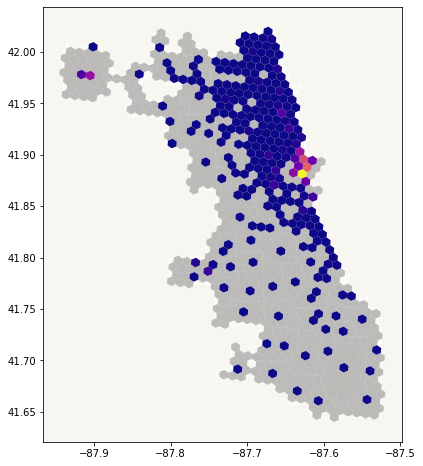

In [19]:
def plot_chicago_heatmap(df,ax,h3_column,feature_column,h3_gdf,filter_value=0,cmap="plasma"):
    data = df[[h3_column,feature_column]]
    data = pd.merge(h3_gdf,data,how="left",left_on="h3_id",right_on=h3_column)
    data[feature_column] = data[feature_column].fillna(0)
    data_below = data[data[feature_column]<=filter_value]
    data_above = data[data[feature_column]>filter_value]
    data_below.plot(ax=ax,color="grey",alpha=0.5,edgecolor="none")
    plot = data_above.plot(ax=ax,column=feature_column,cmap=cmap)
    return plot

fig,ax = plt.subplots(1,1,figsize = (16,8))

chicago_fence = gpd.read_file("../data/chicago-community-areas.geojson")
chicago_fence.plot(ax=ax,edgecolor="white",color="none")

plot = plot_chicago_heatmap(gdf_sliced_pu[gdf_sliced_pu["hour_slice"]==1],ax,"H3","count",h3_gdf,0)

ctx.add_basemap(ax=ax,zoom=12,crs=4326,source='https://a.tile.openstreetmap.fr/hot/{z}/{x}/{y}.png')
chicago_fence.plot(ax=ax,alpha=0) #das macht nur die skalierung richtig

In [7]:
def hex_to_geoboundary(value):
    if isinstance(value,str):
        return shapely.geometry.Polygon(h3.h3_to_geo_boundary(value, True))
    else:
        return np.nan
    
def group_h3_slice(df,timestamp_feature_name,H3_feature_name,slices):
    df_grouped = df.copy()
    divider = 24/slices
    df_grouped["hour_slice"] = np.floor(df_grouped[timestamp_feature_name].dt.hour / divider).astype(int)
    df_grouped = df_grouped.groupby(["hour_slice",H3_feature_name]).agg(count=(H3_feature_name,"count"))
    df_grouped["H3"] = df_grouped.index.get_level_values(1)
    df_grouped["geometry"] = df_grouped.apply(lambda x: hex_to_geoboundary(x["H3"]),axis=1)
    df_grouped["hour_slice"] = df_grouped.index.get_level_values(0)
    return gpd.GeoDataFrame(df_grouped, geometry='geometry')

gdf_sliced_pu = group_h3_slice(df,"Trip Start Timestamp","PU_H3",2)
gdf_sliced_do = group_h3_slice(df,"Trip End Timestamp","DO_H3",2)

In [ ]:
fig,ax = plt.subplots(2,2,figsize = (16,8))

chicago_fence = gpd.read_file("../data/chicago-community-areas.geojson")
 

for i in range(0,2):
    chicago_fence.plot(ax=ax[0,i],edgecolor="white",color="none")
    gdf_sliced_pu[gdf_sliced_pu["hour_slice"]==i].plot(ax=ax[0,i],cmap="plasma",column="count")
    ctx.add_basemap(ax=ax[0,i],zoom=12,crs=4326,source='https://a.tile.openstreetmap.fr/hot/{z}/{x}/{y}.png')
    chicago_fence.plot(ax=ax[0,i],alpha=0) #das macht nur die skalierung richtig

for i in range(0,2):
    chicago_fence.plot(ax=ax[1,i],edgecolor="white",color="none")
    gdf_sliced_do[gdf_sliced_do["hour_slice"]==i].plot(ax=ax[1,i],cmap="plasma",column="count")
    ctx.add_basemap(ax=ax[1,i],zoom=12,crs=4326,source='https://a.tile.openstreetmap.fr/hot/{z}/{x}/{y}.png')
    chicago_fence.plot(ax=ax[1,i],alpha=0) #das macht nur die skalierung richtig

In [ ]:
fig,ax = plt.subplots(figsize = (16,16))
chicago_fence.plot(ax=ax,edgecolor="black",color="none")
ctx.add_basemap(ax=ax,zoom=12,crs=4326,source='https://a.tile.openstreetmap.fr/hot/{z}/{x}/{y}.png')
chicago_fence.plot(ax=ax,alpha=0) #das macht nur die skalierung richtig
h3_gdf.plot(ax=ax)
chicago_fence.plot(ax=ax,edgecolor="none",color="none")